TR AUTO - run 0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from iminuit.cost import LeastSquares

import irdetection.analysis.fitting.models as md
from irdetection.analysis.fitting.FitAPI import Fitter
from irdetection.analysis.fitting.models import Model
from irdetection.analysis.fitting.searcher import ResonancePeakSearcher
from irdetection.graphics.plots import plot_fit
from irdetection.graphics.colours import Palette
from irdetection.graphics.typography import Typography, Font

In [2]:
# graphics settings
palette = Palette("Quantum Science", {
    'primary': "#046A3A",      # Deep ocean blue - sophisticated and trustworthy
    'secondary': '#1B263B',    # Midnight navy - elegant depth
    'accent': "#E65039",       # Vibrant coral - high-impact highlights
    'accent2': '#FFD23F',      # Golden yellow - energy and precision
    'background': '#F8F9FB',   # Ultra-clean off-white - pristine lab feel
    'background2': '#E8EDF3',  # Subtle blue-gray - sophisticated secondary
    'text_primary': '#1A1B23', # Rich charcoal - maximum readability
    'text_secondary': '#4A5568', # Cool gray - perfect for secondary text
    'status_error': '#E53E3E',  # Crisp red - clear error indication
    'neutral_light': "#F3F3F3",  # Cool light gray - subtle grid
    'neutral_dark': "#2D3748",   # Professional dark gray - strong borders
})

typography = Typography(
    title=Font('Palatino Linotype', 20, family='serif'),   
    subtitle=Font('Verdana', 16, family='sans-serif'),
    body=Font('Verdana', 13, family='sans-serif'),    
    caption=Font('Verdana', 11, family='sans-serif')  
)

In [4]:
R_true = 2.317

def read_peaks_data_2(filename):
    data_dict = {}       # stores the dataset values as NumPy arrays
    metadata_dict = {}   # stores the metadata (attributes) for each dataset
    def process_dataset(name, obj):
        if isinstance(obj, h5py.Dataset):
            bias_voltage = float(obj.attrs.get("bias_voltage"))
            bias_key = bias_voltage/R_true 
            if bias_key is not None:
                data_dict[bias_key] = obj[()]
                metadata_dict[bias_key] = {k: v for k, v in obj.attrs.items()}
            else:
                print(f"Warning: Dataset '{name}' missing 'bias_voltage' attribute.")

    with h5py.File(filename, 'r') as f:
        f.visititems(process_dataset)

    return data_dict, metadata_dict

## Peak at 6.23 MHz (run-0)

In [ ]:
peak_data_dict, _ = read_peaks_data_2('../Experiments/TRswipeAuto/run-0/data/tr_sweep_data.h5')

resonance_frequneces = []
bias_currents = []
Qc = []
Qt = []

nof_peaks = len(peak_data_dict) - 4 # Exclude the last 4 peaks (assumed to be non-resonance peaks)
# Calculate grid size to accommodate all peaks - changed to 5 columns
nrows = (nof_peaks + 4) // 5  # Calculate required rows for 5 columns

fig, ax = plt.subplots(nrows, 5, figsize=(30, nrows * 8), gridspec_kw={'hspace':0.4, 'wspace':0.3})

row_iter = 0
col_iter = 0

pippo = 0
for i, (bias_current, peak_data) in enumerate(peak_data_dict.items()):
     
    # Break the cycle for the last 4 values of current:
    if i >= nof_peaks:
        break
    
    f = peak_data[0]
    I = peak_data[1]
    Q = peak_data[2]
    amp = np.sqrt(I**2 + Q**2)
    amp_dBm = 20 * np.log10(amp * 1e3)  # Convert to dBm
    peak_data = np.array([f, amp_dBm]).T
    
    # try to fit
    model = md.resonance_model_test
    
    
    def Loss(*params):
        """Loss function for the resonance model."""
        print(f"Fitting parameters: {params[0]}")
        x, y, yerr, model, names = params
        f0, phi, Qt, Qc, A, B, C, D, K, fmin = [x[names.index(name)] for name in names]
        model_values = model(f0=f0, phi=phi, Qt=Qt, Qc=Qc, A=A, B=B, C=C, D=D, K=K, fmin=fmin)
        ls = np.sum((x - model_values) ** 2)
        if Qc <= Qt:
            ls += 100  # Penalize if Qc is smaller than Qt
        return ls
    
    fitter = Fitter(model_function=model, 
                        param_names=["f0", "phi", "Qc", "Qt", "A", "B", "C", "D", "K", "fmin"], 
                        data=peak_data, 
                        loss_manager=LeastSquares,
                    )

    searcher = ResonancePeakSearcher(version="T")
    result = fitter.fit(searcher=searcher)

    # Check if the fit was successful
    if result.valid:
        # p-value test
        p_value = fitter.p_value()
        if p_value < 0.05:
            print(f"Fit for bias current {bias_current} failed (p-value: {p_value})")
            # For now we take the fmin as the resonance frequency
            resonance_frequency = searcher.params['fmin']
            resonance_frequneces.append(resonance_frequency)
            bias_currents.append(bias_current)
            continue
        else:
            # Extract the resonance frequency from the fitted parameters
            resonance_frequency = result.values['f0'] + searcher.params['fmin']
            resonance_frequneces.append(resonance_frequency)
            bias_currents.append(bias_current)
            fitted_params = result.values.to_dict()
            fitted_params['fmin'] = searcher.params['fmin']
            plot_fit(peak_data, model, fitted_params,
                     title=f'{round(bias_current, 3)} mA', 
                     xlabel='Frequency (GHz)', 
                     ylabel='Amplitude (dBm)', 
                     palette=palette, 
                     typography=typography, 
                     ax=ax[row_iter, col_iter],
                     rasterize_points=True)
            
            Qc.append(fitted_params['Qc'])
            Qt.append(fitted_params['Qt'])
    else:
        print(f"Fit for bias current {bias_current} failed (invalid result)")
        # For now we take the fmin as the resonance frequency
        resonance_frequency = searcher.params['fmin']
        resonance_frequneces.append(resonance_frequency)
        #bias_currents.append(bias_current)
        
    if pippo > 37:
        # delete ax
        fig.delaxes(ax[row_iter, col_iter])

    # update iterators - changed to 5 columns
    col_iter += 1
    pippo+=1
    if col_iter >= 5:  # Changed from 8 to 5 columns
        col_iter = 0
        row_iter += 1
    


plt.show()


(1000, 2)
(1000, 2)
(1000, 2)
Fit for bias current 0.17263703064307293 failed (invalid result)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)


In [ ]:
# Save the figure a pdf file
# fig.savefig('../Analysis/resonance_peaks.pdf', bbox_inches='tight', dpi=300)

## Peak at 5.8 MHz (run-2)

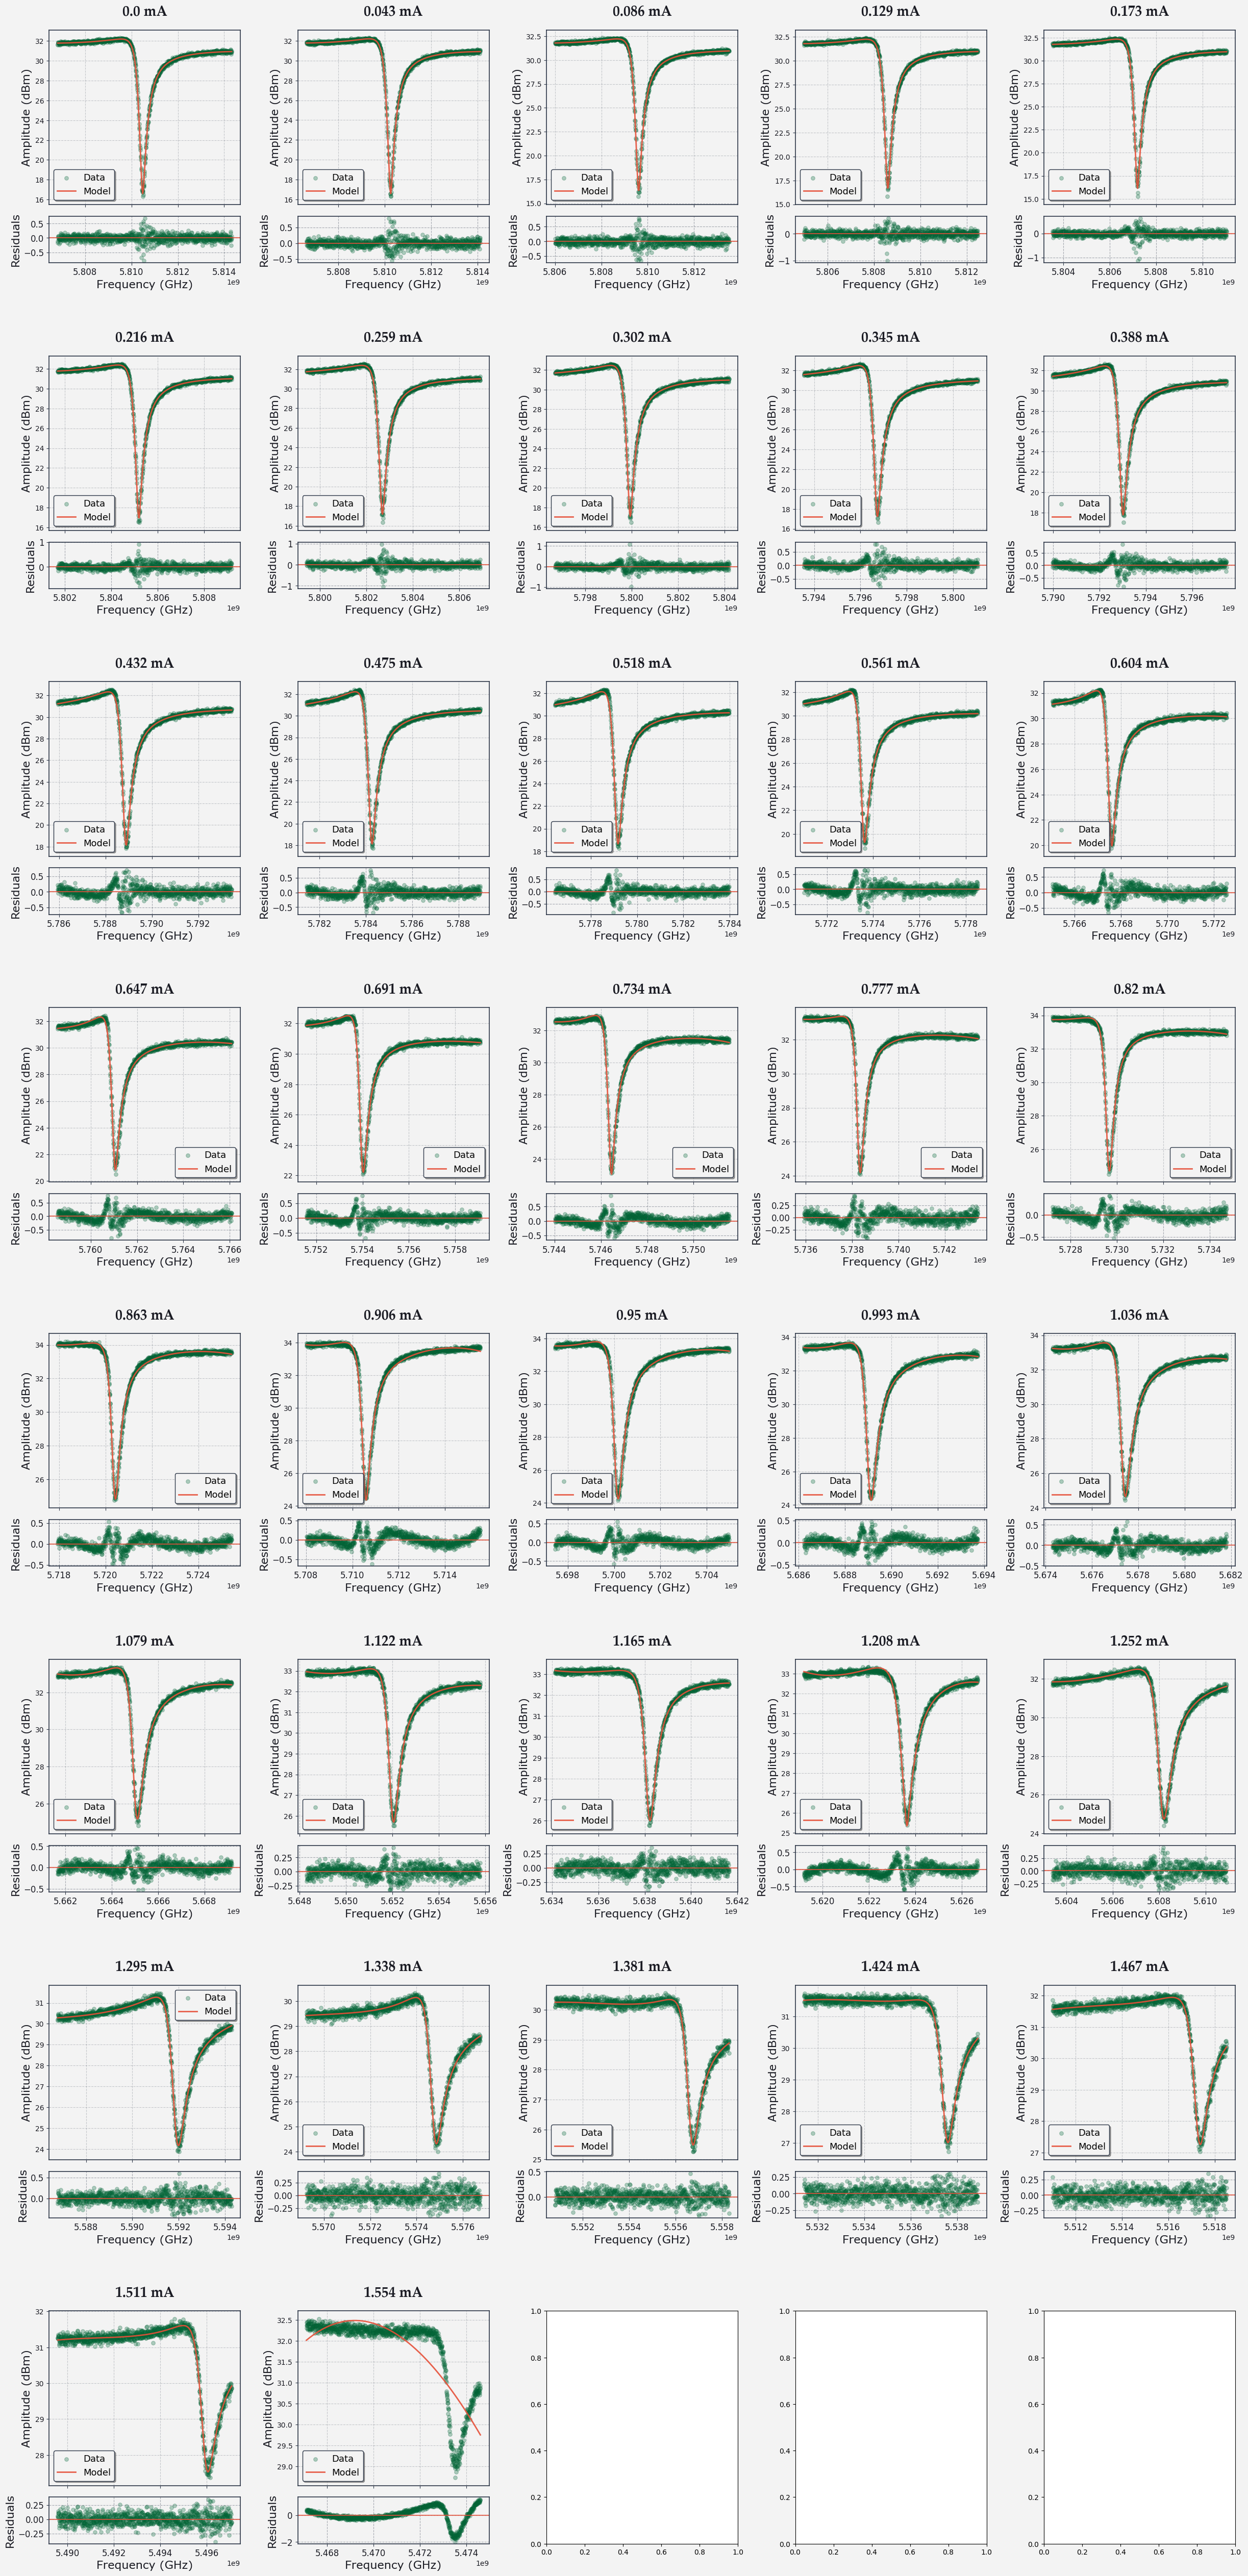

In [7]:
peak_data_dict, _ = read_peaks_data_2('../Experiments/TRswipeAuto/run-2/data/tr_sweep_data.h5')

resonance_frequneces = []
bias_currents = []
Qc = []
Qt = []

nof_peaks = len(peak_data_dict) - 4 # Exclude the last 4 peaks (assumed to be non-resonance peaks)
# Calculate grid size to accommodate all peaks - changed to 5 columns
nrows = (nof_peaks + 4) // 5  # Calculate required rows for 5 columns

fig, ax = plt.subplots(nrows, 5, figsize=(30, nrows * 8), gridspec_kw={'hspace':0.4, 'wspace':0.3})

row_iter = 0
col_iter = 0

pippo = 0
for i, (bias_current, peak_data) in enumerate(peak_data_dict.items()):
     
    # Break the cycle for the last 4 values of current:
    if i >= nof_peaks:
        break
    
    f = peak_data[0]
    I = peak_data[1]
    Q = peak_data[2]
    amp = np.sqrt(I**2 + Q**2)
    amp_dBm = 20 * np.log10(amp * 1e3)  # Convert to dBm
    peak_data = np.array([f, amp_dBm]).T
    
    # try to fit
    model = md.resonance_model
    
    
    def Loss(x, y, yerr, model, names):
        """Loss function for the resonance model."""
        f0, phi, Qt, Qc, A, B, C, D, K, fmin = [x[names.index(name)] for name in names]
        model_values = model(f0=f0, phi=phi, Qt=Qt, Qc=Qc, A=A, B=B, C=C, D=D, K=K, fmin=fmin)
        ls = np.sum((x - model_values) ** 2)
        if Qc <= Qt:
            ls += 100  # Penalize if Qc is smaller than Qt
        return ls
    
    fitter = Fitter(model_function=model, 
                        param_names=["f0", "phi", "Qc", "Qt", "A", "B", "C", "D", "K", "fmin"], 
                        data=peak_data, 
                        loss_function=LeastSquares
                    )

    searcher = ResonancePeakSearcher(version="T")
    result = fitter.fit(searcher=searcher)

    # Check if the fit was successful
    if result.valid:
        # p-value test
        p_value = fitter.p_value()
        if p_value < 0.05:
            print(f"Fit for bias current {bias_current} failed (p-value: {p_value})")
            # For now we take the fmin as the resonance frequency
            resonance_frequency = searcher.params['fmin']
            resonance_frequneces.append(resonance_frequency)
            bias_currents.append(bias_current)
            continue
        else:
            # Extract the resonance frequency from the fitted parameters
            resonance_frequency = result.values['f0'] + searcher.params['fmin']
            resonance_frequneces.append(resonance_frequency)
            bias_currents.append(bias_current)
            fitted_params = result.values.to_dict()
            fitted_params['fmin'] = searcher.params['fmin']
            plot_fit(peak_data, model, fitted_params,
                     title=f'{round(bias_current, 3)} mA', 
                     xlabel='Frequency (GHz)', 
                     ylabel='Amplitude (dBm)', 
                     palette=palette, 
                     typography=typography, 
                     ax=ax[row_iter, col_iter],
                     rasterize_points=True)
            
            Qc.append(fitted_params['Qc'])
            Qt.append(fitted_params['Qt'])
    else:
        print(f"Fit for bias current {bias_current} failed (invalid result)")
        # For now we take the fmin as the resonance frequency
        resonance_frequency = searcher.params['fmin']
        resonance_frequneces.append(resonance_frequency)
        #bias_currents.append(bias_current)
        
    if pippo > 37:
        # delete ax
        fig.delaxes(ax[row_iter, col_iter])

    # update iterators - changed to 5 columns
    col_iter += 1
    pippo+=1
    if col_iter >= 5:  # Changed from 8 to 5 columns
        col_iter = 0
        row_iter += 1
    

plt.show()

## Q analysis

In [5]:
# Renormalize the resonance frequencies with respect to the frequency at 0 bias current
resonance_frequneces_normalized = np.array(resonance_frequneces)
bias_currents = np.array(bias_currents)
resonance_frequneces_normalized -= resonance_frequneces[0]
resonance_frequneces_normalized /= resonance_frequneces[0] if resonance_frequneces[0] != 0 else 1

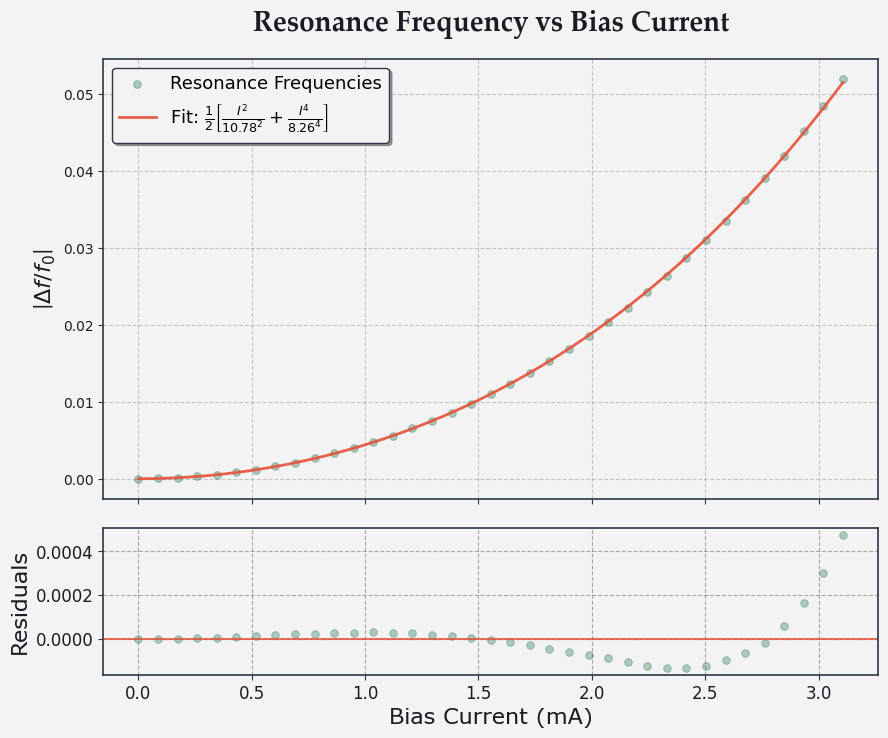

In [18]:
import matplotlib as mpl

# Fit resonance frequency vs bias current
model = md.parametric_resonator_peak_vs_bias_current
fitter = Fitter(model_function=model, 
                    param_names=["a", "b"], 
                    data=np.array([bias_currents, abs(resonance_frequneces_normalized)]).T, 
                    loss_function=LeastSquares,
                    params_initial_guess={"a": 1, "b": 1}, # initial guess for the parameters
                )



result = fitter.fit()
fitted_params = result.values.to_dict()

#model: 0.5*((i**2 / a**2) + (i**4 / b**4))

data = np.array([bias_currents, abs(resonance_frequneces_normalized)]).T
# Plot using LaTeX for text rendering
# enable LaTeX

# disable LaTeX rendering and use mathtext (Matplotlib's built-in math renderer)
mpl.rcParams['text.usetex'] = False

plot_fit(
    data=data,
    model=model,
    model_params=fitted_params,
    title=r'Resonance Frequency vs Bias Current',
    xlabel=r'Bias Current (mA)',
    ylabel=r'$\left|\Delta f / f_0\right|$',  # mathtext will still render this correctly
    data_label=r'Resonance Frequencies',
    model_label=(
        r'Fit: $\frac{1}{2}\left[\frac{I^2}{%.2f^2} + \frac{I^4}{%.2f^4}\right]$'
        % (fitted_params["a"], fitted_params["b"])
    ),
    palette=palette,
    typography=typography,
    rasterize_points=False,
)
plt.show()


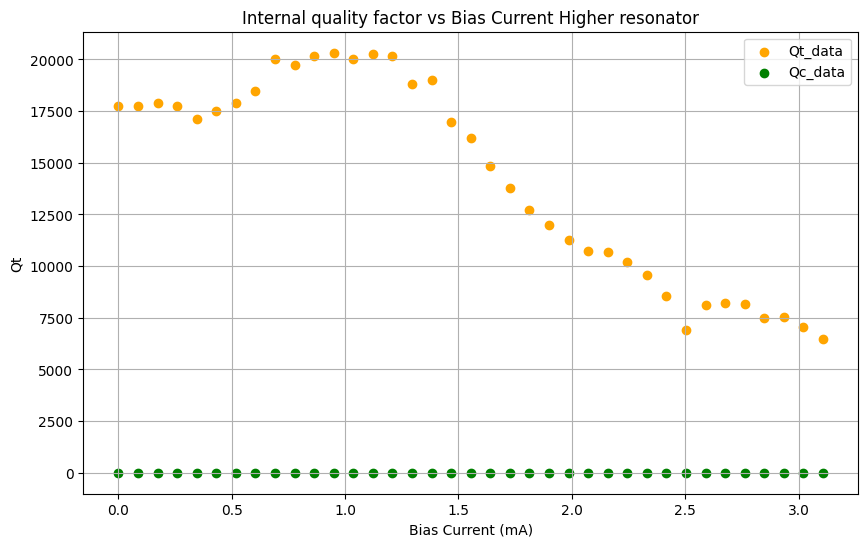

In [39]:
Qt0 = np.array(Qt)
Qc0 = Qt0/np.array(Qc)  # Assuming Qc is calculated as Qt / Qc
Qt1 = (Qt0 + Qc0)/(Qt0*Qc0)  # Assuming Qt is the sum of Qt and Qc

plt.figure(figsize=(10, 6))
# plt.scatter(bias_currents, Qt1, label='Qt_data', color='blue')
plt.scatter(bias_currents, np.array(Qt0), label='Qt_data', color='orange')
plt.scatter(bias_currents, np.array(Qc0), label='Qc_data', color='green')
plt.xlabel('Bias Current (mA)')
plt.ylabel('Qt')
plt.title('Internal quality factor vs Bias Current Higher resonator')
plt.legend()
plt.grid()
plt.show()



F(I) gradient plot (to be fixed)

In [20]:
peak_data

array([[ 5.88182000e+09,  5.88182751e+09,  5.88183502e+09, ...,
         5.88930498e+09,  5.88931249e+09,  5.88932000e+09],
       [-1.64066927e-02, -1.70615392e-02, -1.62847356e-02, ...,
         3.61652918e-02,  3.53263494e-02,  3.52834024e-02],
       [ 2.74783655e-02,  2.89264500e-02,  2.75738108e-02, ...,
         9.34419210e-03,  9.17023870e-03,  9.40279520e-03]],
      shape=(3, 1000))

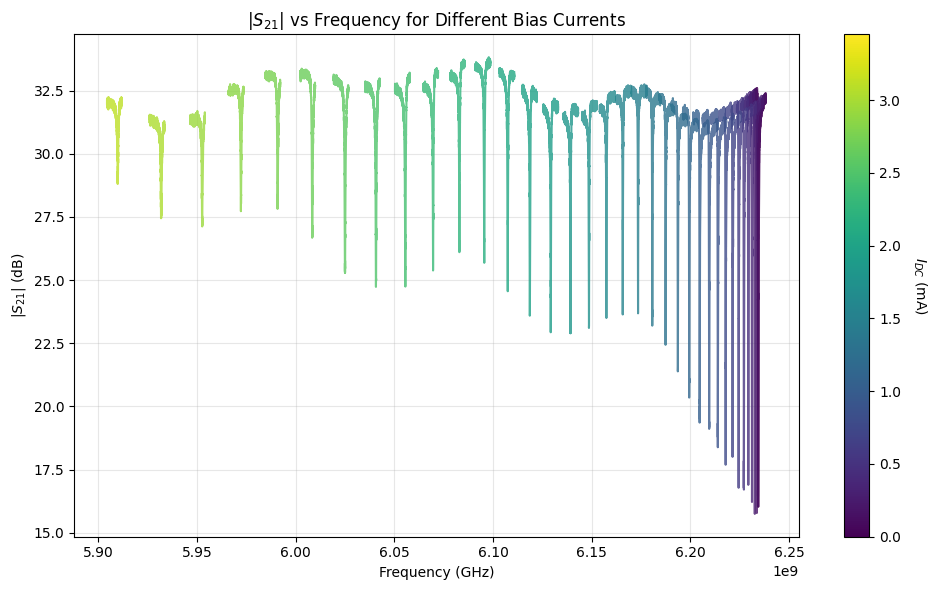

In [21]:

import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Trova i valori min e max dei bias current per normalizzare la colormap
all_bias_currents = list(peak_data_dict.keys())
vmin = min(all_bias_currents)
vmax = max(all_bias_currents)
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('viridis')

for i, (bias_current, peak_data) in enumerate(peak_data_dict.items()):
     
    # Break the cycle for the last 4 values of current:
    if i >= nof_peaks:
        break
    
    f = peak_data[0]
    I = peak_data[1]
    Q = peak_data[2]
    amp = np.sqrt(I**2 + Q**2)
    S21_mag = 20 * np.log10(amp * 1e3)
    color = cmap(norm(bias_current))
    plt.plot(f, S21_mag, color=color, linewidth=1.5, alpha=0.8)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label(r'$I_{DC}$ (mA)', rotation=270, labelpad=20)

# Formatting
plt.xlabel('Frequency (GHz)')
plt.ylabel(r'$|S_{21}|$ (dB)')
plt.title(r'$|S_{21}|$ vs Frequency for Different Bias Currents')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

